In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np

In [26]:
class GRN(nn.Module):
    def __init__(self, d_in, d_hidden, d_out):
        super().__init__()
        self.fc1 = nn.Linear(d_in, d_hidden)
        self.fc2 = nn.Linear(d_hidden, d_out)
        self.gate = nn.Linear(d_out, d_out)
        self.skip = nn.Linear(d_in, d_out) if d_in != d_out else nn.Identity()
        self.norm = nn.LayerNorm(d_out)

    def forward(self, x):
        h = F.elu(self.fc1(x))
        h = self.fc2(h)
        g = torch.sigmoid(self.gate(h))
        return self.norm(g * h + (1 - g) * self.skip(x))


In [27]:
class StaticEncoder(nn.Module):
    def __init__(self, d_static, d_model):
        super().__init__()
        self.grn = GRN(d_static, d_model, d_model)

    def forward(self, s):
        return self.grn(s)


In [28]:
class VariableSelectionNetwork(nn.Module): 
    def __init__(self, num_vars, d_model): 
        super().__init__() 
        self.var_grns = nn.ModuleList(
            [ GRN(1, d_model, d_model) for _ in range(num_vars) ]) 
        self.weight_grn = GRN(num_vars, d_model, num_vars)
         
    def forward(self, x): 
        # x: [B, T, num_vars] 
        var_embeds = []
        for i, grn in enumerate(self.var_grns): 
            var_embeds.append(grn(x[..., i:i+1])) 
        var_embeds = torch.stack(var_embeds, dim=-2) # [B,T,num_vars,d] 
        weights = self.weight_grn(x).softmax(dim=-1) # [B,T,num_vars] 
        fused = (weights.unsqueeze(-1) * var_embeds).sum(dim=-2) 
        return fused, weights

In [29]:
class ContextEnrichment(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.grn = GRN(d_model * 2, d_model, d_model)

    def forward(self, temporal, context):
        context = context.unsqueeze(1).expand_as(temporal)
        return self.grn(torch.cat([temporal, context], dim=-1))


In [30]:
class TemporalAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=num_heads,
            batch_first=True
        )
        self.grn = GRN(d_model, d_model, d_model)

    def forward(self, x):
        T = x.size(1)
        mask = torch.triu(torch.ones(T, T), diagonal=1).bool().to(x.device)
        attn_out, attn_weights = self.attn(x, x, x, attn_mask=mask)
        out = self.grn(attn_out + x)
        return out, attn_weights


In [31]:
class PredictionHead(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        return self.fc(x[:, -1])


In [32]:
class MiniTFT(nn.Module):
    def __init__(self, n_obs, n_known, d_static, d_model=32):
        super().__init__()
        self.static_enc = StaticEncoder(d_static, d_model)

        self.obs_vsn = VariableSelectionNetwork(n_obs, d_model)
        self.known_vsn = VariableSelectionNetwork(n_known, d_model)

        self.enrich = ContextEnrichment(d_model)
        self.attn = TemporalAttention(d_model, num_heads=4)
        
        self.post_attn_grn = GRN(d_model, d_model, d_model)
        self.layer_norm = nn.LayerNorm(d_model)
        
        self.head = PredictionHead(d_model)

    def forward(self, obs, known, static):
        # Preparation for 3 types of inputs
        s = self.static_enc(static)
        obs_fused,_ = self.obs_vsn(obs)
        known_fused,_ = self.known_vsn(known)
        # Locality enhanchement
        x = obs_fused + known_fused
        # Temporal processing
        x = self.enrich(x, s)
        # Temporal attention
        attn_out,attn_weights = self.attn(x)
        x = self.layer_norm(attn_out + x)
        x = self.layer_norm(self.post_attn_grn(x) + x)
        return self.head(x), attn_weights


In [33]:

df = pd.read_parquet("../../data/features/BTC_features.parquet")
print(df.shape)
print(df.info())
print(df.head(1))
print("---------------------------------------")
print(df.columns.tolist())


(5481, 819)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5481 entries, 2010-12-09 to 2025-12-10
Columns: 819 entries, open to ret_lag_144
dtypes: float64(817), object(2)
memory usage: 34.3+ MB
None
                open      high      low     close    volume symbol  \
date                                                                 
2010-12-09 -0.674481 -0.676188 -0.67272 -0.674708 -0.640733    BTC   

                   source  building_permits  consumer_confidence       cpi  \
date                                                                         
2010-12-09  alpha_vantage         -2.064399            -0.387082 -1.290801   

            ...  close_lag_21  ret_lag_21  close_lag_34  ret_lag_34  \
date        ...                                                       
2010-12-09  ...     -0.669729    3.274749     -0.667228    2.574162   

            close_lag_55  ret_lag_55  close_lag_89  ret_lag_89  close_lag_144  \
date                                                 

In [34]:
static_cols = ["symbol", "source"]
observed_cols = [
    "open", "high", "low", "close", "volume",
    "ema_34", "ema_89", "ema_200",
    "rsi_14", "macd", "log_return", "vol_20"
] + [c for c in df.columns if "lag_" in c]
known_cols = [
    "building_permits", "consumer_confidence", "cpi",
    "fed_funds_rate", "gdp", "industrial_production",
    "money_supply_m1", "money_supply_m2",
    "nonfarm_payrolls", "pce_inflation",
    "ppi", "retail_sales", "trade_balance",
    "unemployment_rate"
] + [c for c in df.columns if c.startswith("fed_emb_")]
target_col = "next_close"

# train val test splitting
n = len(df)
train_end = int(0.70 * n)
val_end = int(0.85 * n)

df_train = df.iloc[:train_end]
df_val   = df.iloc[train_end:val_end]
df_test  = df.iloc[val_end:]


X_train = df_train[observed_cols + known_cols]
X_val   = df_val[observed_cols + known_cols]
X_test  = df_test[observed_cols + known_cols]

y_train = df_train[target_col].values
y_val   = df_val[target_col].values
y_test  = df_test[target_col].values
# Sliding window
LOOKBACK = 89

def build_windows(X, y, lookback):
    X_out, y_out = [], []
    for i in range(lookback, len(X)):
        X_out.append(X[i-lookback:i])
        y_out.append(y[i])
    return np.array(X_out), np.array(y_out)

Xtr, ytr = build_windows(X_train, y_train, LOOKBACK)
Xva, yva = build_windows(X_val, y_val, LOOKBACK)
Xte, yte = build_windows(X_test, y_test, LOOKBACK)

# split input feature tensors
n_obs   = len(observed_cols)
n_known = len(known_cols)
# test Tensor
obs_tr   = Xtr[:, :, :n_obs]
known_tr = Xtr[:, :, n_obs:]
static_tr = np.zeros((len(Xtr), 2))  # placeholder encoding
# validation Tensor
obs_va   = Xva[:, :, :n_obs]
known_va = Xva[:, :, n_obs:]
static_va = np.zeros((len(Xva), 2))


In [35]:
def count_parameters(model):
    # Total parameters (including those frozen/not being trained)
    total_params = sum(p.numel() for p in model.parameters())
    
    # Trainable parameters only
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    return total_params

# Usage:
model = MiniTFT(n_obs=n_obs,
    n_known=n_known,
    d_static=2,
    d_model=32)
count_parameters(model)

Total Parameters: 2,567,785
Trainable Parameters: 2,567,785


2567785

In [36]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import os 
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
from tqdm import tqdm
import gc
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler 
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [ ]:
#CPu run
device = "cpu"

model = MiniTFT(
    n_obs=n_obs,
    n_known=n_known,
    d_static=2,
    d_model=32
).to(device)

pred = model(
    torch.tensor(obs_tr).float().to(device),
    torch.tensor(known_tr).float().to(device),
    torch.tensor(static_tr).float().to(device)
)

In [13]:
# Testing only 
device = "cuda" if torch.cuda.is_available() else "cpu"
# Try only 32 samples instead of the whole dataset
batch_size = 32

model = MiniTFT(
    n_obs=n_obs,
    n_known=n_known,
    d_static=2,
    d_model=32
).to(device)

with torch.no_grad(): # Use this for testing
    pred, weights = model(
        torch.tensor(obs_tr[:batch_size]).float().to(device),
        torch.tensor(known_tr[:batch_size]).float().to(device),
        torch.tensor(static_tr[:batch_size]).float().to(device)
    )

print("Prediction shape:", pred.shape)
print("Attention weights shape:", weights.shape)

c:\ProgramData\miniconda3\Lib\site-packages\torch\nn\modules\module.py:1326: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\cb\pytorch_1000000000000\work\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


Prediction shape: torch.Size([32, 1])
Attention weights shape: torch.Size([32, 89, 89])


In [42]:
def plot_losses(train_losses, val_losses):
    clear_output(wait=True)

    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label="Training Loss", linewidth=2)
    plt.plot(val_losses, label="Validation Loss", linewidth=2)

    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (log Scale) ")
    plt.title("MiniTFT Training vs Validation Loss")
    plt.legend()
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.tight_layout()

    plt.show()


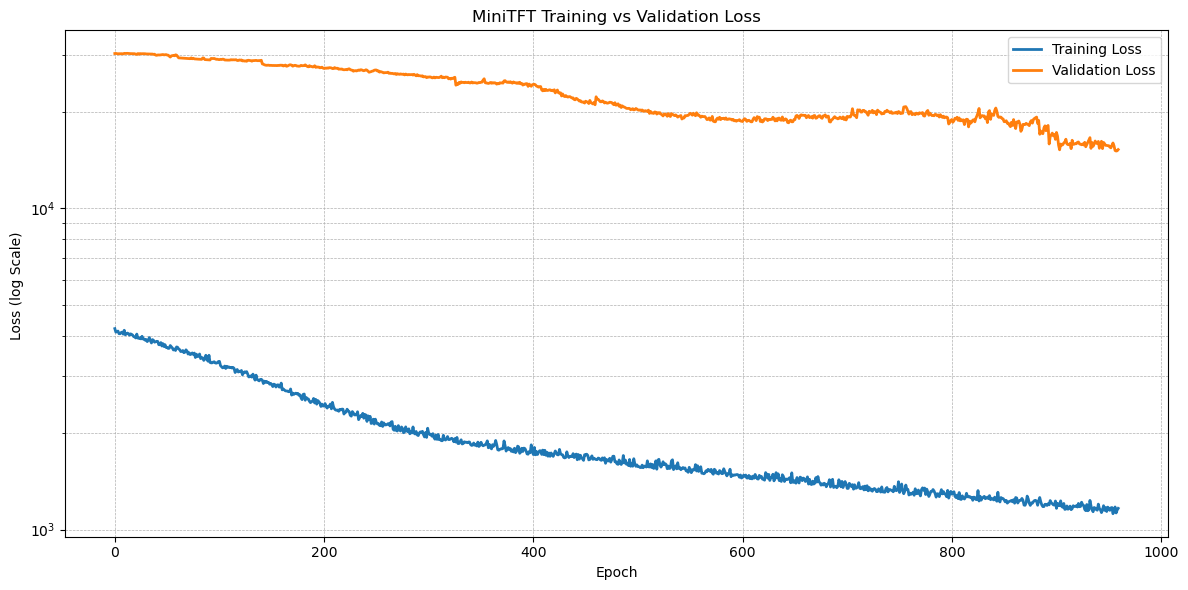

Epoch 1100 | Train Loss: 1164.6180 | Val Loss: 15657.2604
Epoch 1101 | Train Loss: 1147.6454 | Val Loss: 15503.2578
Epoch 1102 | Train Loss: 1168.0750 | Val Loss: 15421.2179
Epoch 1103 | Train Loss: 1171.1050 | Val Loss: 15686.5256
Epoch 1104 | Train Loss: 1120.4474 | Val Loss: 15967.7819
Epoch 1105 | Train Loss: 1140.8136 | Val Loss: 15637.7477
Epoch 1106 | Train Loss: 1175.7308 | Val Loss: 15131.4859
Epoch 1107 | Train Loss: 1126.6807 | Val Loss: 15070.3442
Epoch 1108 | Train Loss: 1150.1814 | Val Loss: 15096.5668
Epoch 1109 | Train Loss: 1164.1692 | Val Loss: 15229.7222
 Model exported successfully to: ..\Model\MiniTFT_Checkpoints\mini_tft_checkpoint.pt


0

In [44]:
#GPU run

CHECKPOINT_DIR = Path("../Model/MiniTFT_Checkpoints")
CHECKPOINT_DIR.mkdir(exist_ok=True)

CHECKPOINT_PATH = CHECKPOINT_DIR / "mini_tft_checkpoint.pt"

device = "cuda"

model = MiniTFT(
    n_obs=n_obs,
    n_known=n_known,
    d_static=2,
    d_model=32
).to(device)

#------- Wrap data in a Dataset
train_dataset = TensorDataset(
    torch.tensor(obs_tr).float(),
    torch.tensor(known_tr).float(),
    torch.tensor(static_tr).float(),
    torch.tensor(ytr).float()
)

val_dataset = TensorDataset(
    torch.tensor(obs_va).float(),
    torch.tensor(known_va).float(),
    torch.tensor(static_va).float(),
    torch.tensor(yva).float()
)

# ----------- Create a DataLoader for batching
train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, pin_memory=True,persistent_workers=True, num_workers=4)
val_loader = DataLoader(
    val_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=4, persistent_workers=True)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#criterion = torch.nn.MSELoss()
criterion = torch.nn.HuberLoss(delta=1.0)
scaler = GradScaler()
start_epoch = 0

#---------- Load checkpoint if exists
train_loss_history = []
val_loss_history = []
epoch_logs = []
if CHECKPOINT_PATH.exists():
    print("Loading previous checkpoint...")

    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    train_loss_history = checkpoint.get("train_loss_history", [])
    val_loss_history   = checkpoint.get("val_loss_history", [])
    
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scaler.load_state_dict(checkpoint["scaler_state"])
    start_epoch = checkpoint["epoch"] + 1

    print(f"Resumed from epoch {start_epoch}")
else:
    print("No checkpoint found. Starting fresh training.")

print(f"Starting inference on {len(train_dataset)} samples...")
EPOCHS = 960

for epoch in range(start_epoch, start_epoch + EPOCHS):
    #-------Training
    model.train()
    train_loss = 0.0

    for batch_obs, batch_known, batch_static, target in tqdm(
        train_loader, desc=f"Epoch {epoch}"
    ):
        optimizer.zero_grad(set_to_none=True)

        with autocast():
            batch_obs = batch_obs.to(device)
            batch_known = batch_known.to(device)
            batch_static = batch_static.to(device)
            target = target.to(device).unsqueeze(-1)

            output, _ = model(batch_obs, batch_known, batch_static)
            loss = criterion(output, target)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    
    #-------Validation
    model.eval()
    val_loss= 0.0
    with torch.no_grad():
        for batch_obs, batch_known, batch_static, target in val_loader:
            with autocast():
                batch_obs = batch_obs.to(device)
                batch_known = batch_known.to(device)
                batch_static = batch_static.to(device)
                target = target.to(device).unsqueeze(-1)

                preds, _ = model(batch_obs, batch_known, batch_static)
                loss = criterion(preds, target)

            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_loss_history.append(val_loss)
    plot_losses(train_loss_history, val_loss_history)
    log_line = (
        f"Epoch {epoch} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f}"
    )
    epoch_logs.append(log_line)
    print("\n".join(epoch_logs[-10:]))

# ------Save model and checkpoint
    torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scaler_state": scaler.state_dict(),
                "train_loss_history": train_loss_history,
                "val_loss_history": val_loss_history,
            },
            CHECKPOINT_PATH,
        )

print(f" Model exported successfully to: {CHECKPOINT_PATH}")
torch.cuda.empty_cache()
gc.collect()

### example prediction using model (currently have error)

In [ ]:
model.eval()

checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state"])


C:\Users\PC\AppData\Local\Temp\ipykernel_24860\3857762638.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)


<All keys matched successfully>

In [45]:
with torch.no_grad():
    obs = torch.tensor(obs_tr).float().to(device)
    known = torch.tensor(known_tr).float().to(device)
    static = torch.tensor(static_tr).float().to(device)

    preds, _ = model(obs, known, static)

preds = preds.squeeze(-1).cpu().numpy()

# Visualization
plt.figure(figsize=(14, 6))

plt.plot(actual_close, label="Actual Price", linewidth=2)
plt.plot(predicted_price, label="Predicted Price", linestyle="--")

plt.title("MiniTFT Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)

plt.show()


OutOfMemoryError: CUDA out of memory. Tried to allocate 42.00 MiB. GPU 0 has a total capacity of 12.00 GiB of which 0 bytes is free. Of the allocated memory 24.21 GiB is allocated by PyTorch, and 1.71 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)